In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import numpy as np
import cv2
import random
from matplotlib import pyplot as plt

from experiment import Experiment
from Network_mask import Net_1, Net_2,Net_1_bis, Training_fusion,Training_dissociated
from DNN_structure_visu import Network_Visualization




# REPRODUCIBILITY
def set_seed(seed=None, seed_torch=True):

    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
DEVICE = torch.device("cpu")
G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)


#HELPER FUNCTION
def print_params(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)





#######________MAIN________#######



experiment = Experiment(width=10,g_seed = G_SEED)
model = Net_2(input_dimension = 5, output_dimension = 2)

display_on = True




Size_total_dataset = experiment.width * experiment.width
Number_of_blocks= 25  # 
Number_of_trials = 10  # Equivalent to Batch size
n_epochs = 2000
learning_rate = 0.00001


Random seed 2021 has been set.


In [ ]:
# REPRODUCIBILITY
def set_seed(seed=None, seed_torch=True):

    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
DEVICE = torch.device("cpu")
G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)


#####################FUSION#################
fusion = True



train_loader,val_loader = experiment.Create_Dataset(NUMBER_OF_BLOCKS = Number_of_blocks,NUMBER_OF_TRIALS  = Number_of_trials,FUSION = fusion)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.BCELoss()
train = Training_fusion(model,optimizer,criterion)


print("Size val_loader",len(val_loader))
print("Size train_loader",len(train_loader))

losses = []
val_losses = []
plt.figure(1)

for epoch in range(n_epochs):
    loss = 0
    val_loss = 0 
    for x_batch, y_batch in train_loader:
        pumpkin_seed = x_batch[0][4]
        #print(pumpkin_seed)

        loss += train.train_network(x_batch, y_batch,pumpkin_seed).detach().numpy()
        #visu = Network_Visualization(display = display_on,magnification=800,Model = model,input_size=5)
        #visu.draw()
    #print("loss",loss)
    losses.append(loss/len(train_loader))
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            model.eval()
            
            with torch.no_grad():
               
                pumpkin_seed = x_val[0][4]
                yhat = model.forward(x_val)
                val_loss += criterion(yhat,y_val)
        #print("val_loss.item()",val_loss.item())
        val_losses.append(val_loss.item()/len(val_loader))





    l_epoch = [i for i in range(len(losses))]
    l_epoch_val = [i for i in range(len(val_losses))]


    plt.plot(l_epoch,losses, '-', color='lightgrey', label='Train')
    plt.plot(l_epoch_val,val_losses, '-', label='Val')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
plt.legend()





In [ ]:
i = 0
for x_val, y_val in val_loader:
    if i<2:
        print("X_VAL",x_val)
        print("Y_VAL",y_val)
        i+=1

Random seed 2021 has been set.
Size val_loader 25
Size train_loader 25


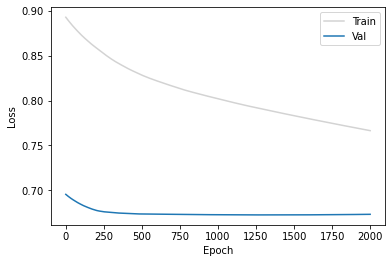

In [2]:


# REPRODUCIBILITY
def set_seed(seed=None, seed_torch=True):

    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)

    print(f'Random seed {seed} has been set.')

SEED = 2021
set_seed(seed=SEED)
DEVICE = torch.device("cpu")
G_SEED = torch.Generator()
G_SEED.manual_seed(SEED)


#HELPER FUNCTION
def print_params(model):
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name, param.data)



fusion = False



train_loader,val_loader = experiment.Create_Dataset(NUMBER_OF_BLOCKS = Number_of_blocks,NUMBER_OF_TRIALS  = Number_of_trials,FUSION = fusion)

experiment = Experiment(width=10,g_seed = G_SEED)
model_spatial = Net_1(input_dimension = 5, output_dimension = 1)
model_conceptual = Net_1(input_dimension = 5, output_dimension = 1)



display_on = True
visu = Network_Visualization(display = display_on,magnification=800,Model = model_spatial,input_size=5)
visu.draw()
optimizer_spatial = torch.optim.Adam(model_spatial.parameters(), lr = learning_rate)
optimizer_conceptual = torch.optim.Adam(model_conceptual.parameters(), lr = learning_rate)


criterion = nn.BCELoss()

train_spatial = Training_dissociated(model_spatial,optimizer_spatial,criterion)
train_conceptual = Training_dissociated(model_conceptual,optimizer_conceptual,criterion)



print("Size val_loader",len(val_loader))
print("Size train_loader",len(train_loader))

losses = []
val_losses = []
for epoch in range(n_epochs):
    loss = 0
    val_loss = 0 
    for x_batch, y_batch in train_loader:
        
        pumpkin_seed = x_batch[0][4]
        if pumpkin_seed == 1:
            loss += train_spatial.train_network(x_batch, y_batch).detach().numpy()
        else:
            loss += train_conceptual.train_network(x_batch, y_batch).detach().numpy()
    #print("loss",loss)
    losses.append(loss/len(train_loader))
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            model_spatial.eval()
            model_conceptual.eval()
            
            with torch.no_grad():
               
                pumpkin_seed = x_val[0][4]
                
                if pumpkin_seed == 1:
                    yhat = model_spatial.forward(x_val)
                else:
                    yhat = model_conceptual.forward(x_val)
                val_loss += criterion(yhat,y_val.unsqueeze(1))
        #print("val_loss.item()",val_loss.item())
        val_losses.append(val_loss.item()/len(val_loader))





l_epoch = [i for i in range(len(losses))]
l_epoch_val = [i for i in range(len(val_losses))]

plt.figure()
plt.plot(l_epoch,losses, '-', color='lightgrey', label='Train')
plt.plot(l_epoch_val,val_losses, '-', label='Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()




